<h1 align=Center>Personalized cancer diagnosis</h1>

In [1]:
import streamlit as st
import os
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import time
import re
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
import random
import joblib
import math
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings("ignore")

random_state = 42
np.random.seed(random_state)
random.seed(random_state)
from collections import Counter, defaultdict
from scipy.sparse import hstack

# Importing utility functions from parent directory. Can't keep in pages as it creates menu in sidebar here.
import sys 
sys.path.insert(0, '../')
from utilities import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kmistri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Environment Variables

# For notebooks Path will have to go to parent directory so path will be "../XXXX"
# For streamlit pages folder it will be managed through parent directory only so path will be "./XXXX"
TRAIN_DATA_DIR = "../train_data/" 
TEST_DATA_DIR = "../test_data/"
PROCESSED_DATA_DIR = "../preprocessed/"
MODELS_DIR = "../models/"


<h3>1. Reading Data</h3>
<p>training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
   Fields are 
   <ul>
       <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
       <li><b>Gene : </b>the gene where this genetic mutation is located </li>
       <li><b>Variation : </b>the aminoacid change for this mutations </li>
       <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
   </ul>

In [3]:
data = pd.read_csv(TRAIN_DATA_DIR+'training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
data_text =pd.read_csv(TRAIN_DATA_DIR+"training_text",sep="\|\|",engine="python",names=["ID","Text"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'Text']


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h3>2. Preprocessing of text</h3>

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kmistri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [7]:
#text processing stage.
for index, row in data_text.iterrows():
    if type(row['Text']) is str:
        nlp_preprocessing(row['Text'], index, 'Text')
    else:
        print("there is no text description for id:",index)

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755


In [8]:
#merging both gene_variations and text data based on ID
merged_results = pd.merge(data, data_text,on='ID', how='left')
merged_results.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [9]:
merged_results[merged_results.isnull().any(axis=1)]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [10]:
merged_results.loc[merged_results['Text'].isnull(),'Text'] = merged_results['Gene'] +' '+merged_results['Variation']

In [11]:
merged_results[merged_results['ID']==1109]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,FANCA S1088F


<h3>3. Test, Train and Cross Validation Split</h3>
<li>Splitting data into train, test and cross validation (64:20:16)</li>
<li> We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set using statify split feature based on class</li>

In [12]:
y_true = merged_results['Class'].values
merged_results.Gene      = merged_results.Gene.str.replace('\s+', '_',regex=True)
merged_results.Variation = merged_results.Variation.str.replace('\s+', '_',regex=True)

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(merged_results, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [13]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h4>3.1. Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

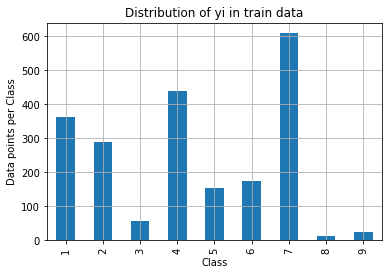

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


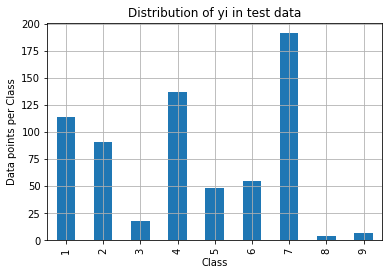

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


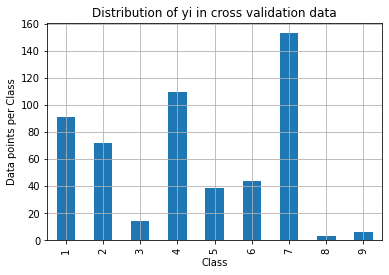

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [14]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


<h3>Exploratory Data Analysis</h3>

<h4>3.2 Prediction using a 'Random' Model</h4>

In [15]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

<p style="font-size:16px"> In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1. </p>

Log loss on Cross Validation Data using Random Model 2.450964298929681
Log loss on Test Data using Random Model 2.5194404639993384
-------------------- Confusion matrix --------------------


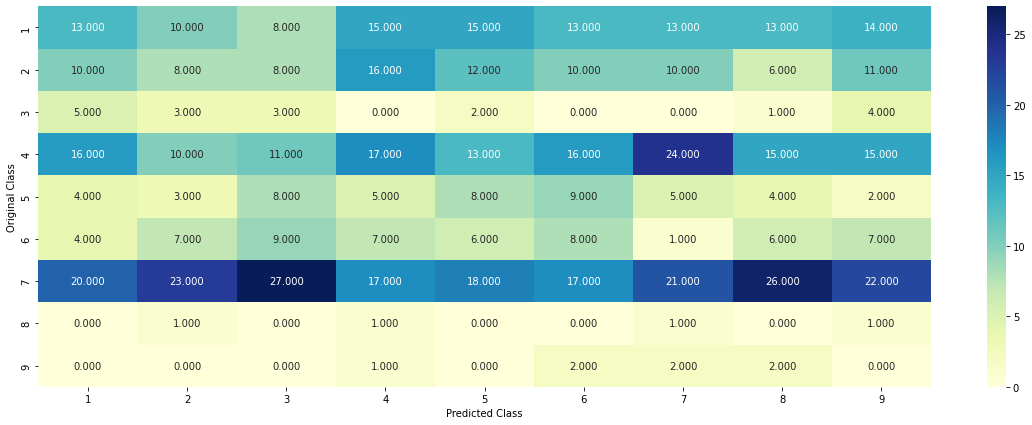

-------------------- Precision matrix (Columm Sum=1) --------------------


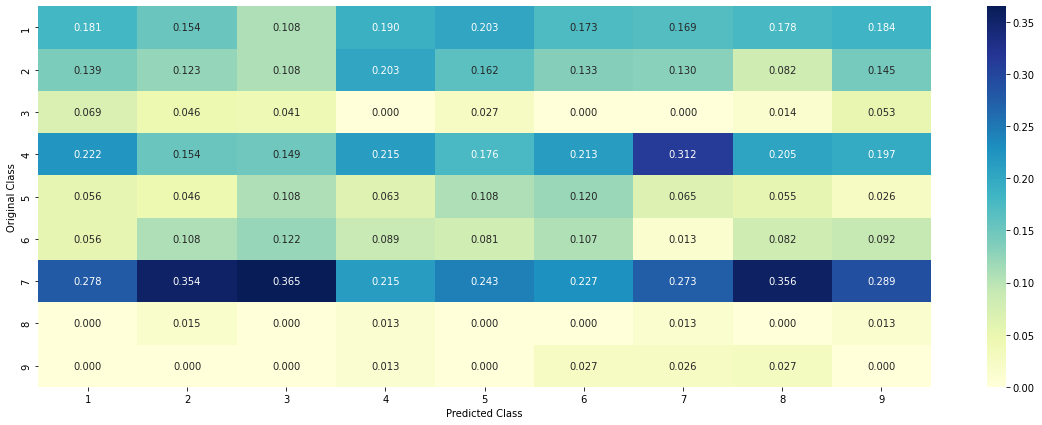

-------------------- Recall matrix (Row sum=1) --------------------


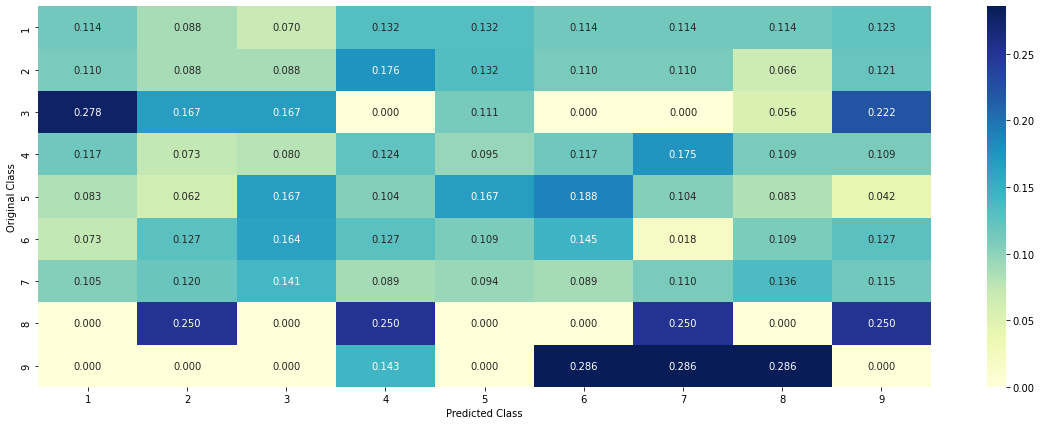

In [16]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

<h4>3.3 Univariate Analysis</h4>

In [17]:
# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    """
        code for response coding with Laplace smoothing.
        alpha : used for laplace smoothing
        feature: ['gene', 'variation']
        df: ['train_df', 'test_df', 'cv_df']
        algorithm
        ----------
        Consider all unique values and the number of occurances of given feature in train data dataframe
        build a vector (1*9), 
        
        the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
        
        gv_dict is like a look up table, for every gene it store a (1*9) representation of it
        
        for a value of feature in df:
            if it is in train data:
                we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
            if it is not there is train:
                we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
            return 'gv_fea'
        ----------------------
    """
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            # when we caculate the probability of a feature belongs to any particular class, 
            # we apply laplace smoothing = (numerator + 10*alpha) / (denominator + 90*alpha)
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

<h5>3.2.1 Univariate Analysis on Gene Feature</h5>

1. How many categories are there and How they are distributed?

Ans: There are 229 different categories of genes in the train data, and they are distibuted as follows

In [18]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 232
BRCA1     165
TP53      103
EGFR       94
PTEN       87
BRCA2      83
KIT        65
BRAF       59
ALK        49
PDGFRA     45
ERBB2      41
Name: Gene, dtype: int64


In [19]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 232 different categories of genes in the train data, and they are distibuted as follows


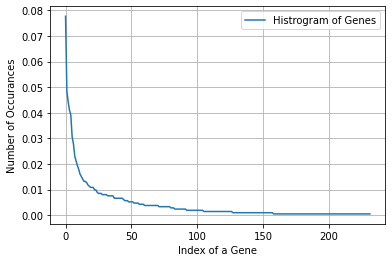

In [20]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


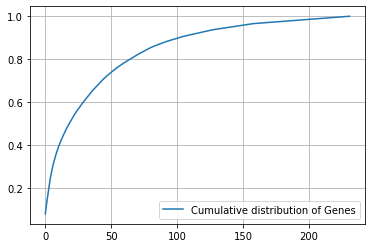

In [21]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

2. How to featurize this Gene feature ?

Ans. there are two ways we can featurize this variable
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will choose the appropriate featurization based on the ML model we use.  For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests. </p>

In [22]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [23]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [24]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [25]:
train_df['Gene'].head()

2447    BRCA1
2718     BRAF
796     ERBB4
1710     POLE
345      CDH1
Name: Gene, dtype: object

In [26]:
gene_vectorizer.get_feature_names_out()

array(['abl1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc', 'ar', 'araf',
       'arid1a', 'arid1b', 'arid2', 'arid5b', 'asxl2', 'atm', 'atr',
       'atrx', 'aurka', 'axl', 'b2m', 'bap1', 'bard1', 'bcl10', 'bcl2',
       'bcor', 'braf', 'brca1', 'brca2', 'brd4', 'brip1', 'btk', 'card11',
       'carm1', 'casp8', 'cbl', 'ccnd1', 'ccnd2', 'ccnd3', 'ccne1',
       'cdh1', 'cdk12', 'cdk4', 'cdk6', 'cdk8', 'cdkn1a', 'cdkn1b',
       'cdkn2a', 'cdkn2b', 'cdkn2c', 'chek2', 'cic', 'crebbp', 'ctcf',
       'ctla4', 'ctnnb1', 'ddr2', 'dicer1', 'dnmt3a', 'dnmt3b', 'dusp4',
       'egfr', 'elf3', 'ep300', 'epas1', 'epcam', 'erbb2', 'erbb3',
       'erbb4', 'ercc2', 'ercc3', 'ercc4', 'erg', 'errfi1', 'esr1',
       'etv1', 'etv6', 'ewsr1', 'ezh2', 'fanca', 'fancc', 'fat1', 'fbxw7',
       'fgf3', 'fgf4', 'fgfr1', 'fgfr2', 'fgfr3', 'fgfr4', 'flt3',
       'foxa1', 'foxl2', 'foxp1', 'gata3', 'gli1', 'gna11', 'gnas',
       'h3f3a', 'hnf1a', 'hras', 'idh1', 'idh2', 'igf1r', 'ikbke',
       'inpp4b',

In [27]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 232)


3. How good is this gene feature  in predicting Class?

<li>There are many ways to estimate how good a feature is, in predicting Class values. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict Class values.</li>

For values of alpha =  1e-05 The log loss is: 1.18188418614008
For values of alpha =  0.0001 The log loss is: 1.156662655182175
For values of alpha =  0.001 The log loss is: 1.1930204340656967
For values of alpha =  0.01 The log loss is: 1.3103079367556014
For values of alpha =  0.1 The log loss is: 1.4248968159958058
For values of alpha =  1 The log loss is: 1.4633842405045299


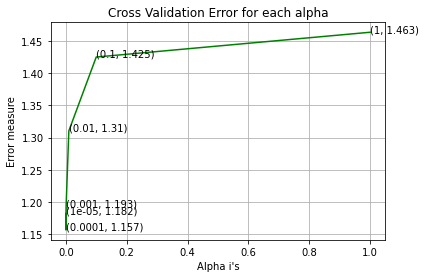

For values of best alpha =  0.0001 The train log loss is: 0.9863460569021284
For values of best alpha =  0.0001 The cross validation log loss is: 1.156662655182175
For values of best alpha =  0.0001 The test log loss is: 1.2388468155316459


In [28]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

# Refer: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=random_state)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=random_state)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


4. Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?

Ans. Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. 

In [29]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  232  genes in train dataset?
Ans
1. In test data 640 out of 665 : 96.2406015037594
2. In cross validation data 518 out of  532 : 97.36842105263158


<h5>3.2.2 Univariate Analysis on Variation Feature</h5>

1. How many categories are there?

In [30]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1925
Truncating_Mutations    59
Amplification           52
Deletion                49
Fusions                 21
Overexpression           3
Q61R                     3
P34R                     2
E542K                    2
F384L                    2
Y42C                     2
Name: Variation, dtype: int64


In [31]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1925 different categories of variations in the train data, and they are distibuted as follows


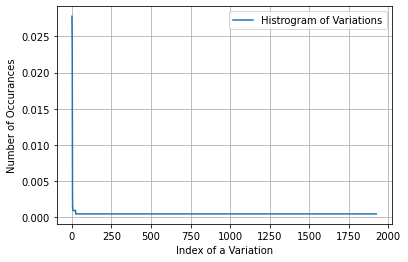

In [32]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02777778 0.05225989 0.07532957 ... 0.99905838 0.99952919 1.        ]


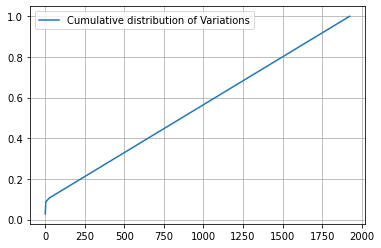

In [33]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

2. How to featurize this Variation feature ?

Ans. There are two ways we can featurize this variable
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>

In [34]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [35]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [36]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [37]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1954)


3. How good is this Variation feature  in predicting Class?

For values of alpha =  1e-05 The log loss is: 1.7006883742126457
For values of alpha =  0.0001 The log loss is: 1.695322808366601
For values of alpha =  0.001 The log loss is: 1.6951701931786995
For values of alpha =  0.01 The log loss is: 1.7004055457183054
For values of alpha =  0.1 The log loss is: 1.7093449201246347
For values of alpha =  1 The log loss is: 1.7117426813249064


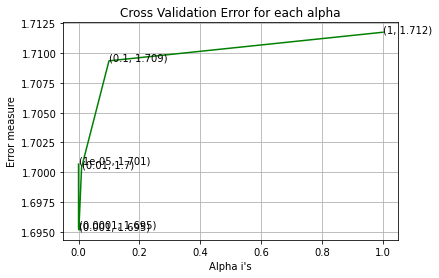

For values of best alpha =  0.001 The train log loss is: 1.06239859094768
For values of best alpha =  0.001 The cross validation log loss is: 1.6951701931786995
For values of best alpha =  0.001 The test log loss is: 1.7277620504246631


In [38]:
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=random_state)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=random_state)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


4. Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?

<p style="font-size:16px;"> <b>Ans.</b> Not sure! But lets be very sure using the below analysis. </p>

In [39]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1925  genes in test and cross validation data sets?
Ans
1. In test data 64 out of 665 : 9.624060150375941
2. In cross validation data 55 out of  532 : 10.338345864661653


<h5>3.2.3 Univariate Analysis on Text Feature</h5>

1. How many unique words are present in train data?

Ans. Total number of unique words in train data : 52608

In [40]:
def extract_dictionary_paddle(cls_text):
    """
    Usage: extract_dictionary_paddle(cls_text)
    Inputs: cls_text is a data frame
    Output: Dictionary
    
    >>> for every row in data fram consider the 'Text' split the words by space
    make a dict with those words increment its count whenever we see that word
    """
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['Text'].split():
            dictionary[word] +=1
    return dictionary

In [41]:
import math

def get_text_responsecoding(df):
    """ https://stackoverflow.com/a/1602964"""
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['Text'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['Text'].split()))
            row_index += 1
    return text_feature_responseCoding

In [42]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['Text'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52405


In [43]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [44]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [45]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [46]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['Text'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['Text'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [47]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

2. How are word frequencies distributed?

In [48]:
print(Counter(sorted_text_occur))

Counter({3: 5009, 4: 3392, 6: 2810, 5: 2548, 7: 2336, 9: 2294, 8: 1802, 10: 1398, 12: 1216, 11: 1014, 15: 911, 14: 879, 13: 846, 18: 791, 16: 777, 17: 641, 20: 618, 21: 516, 19: 494, 24: 476, 22: 448, 25: 384, 29: 377, 30: 358, 27: 357, 42: 351, 23: 351, 26: 349, 28: 314, 33: 298, 32: 288, 36: 286, 47: 282, 31: 256, 35: 241, 34: 232, 38: 219, 39: 213, 37: 205, 40: 204, 48: 196, 46: 190, 44: 190, 45: 182, 54: 178, 41: 168, 43: 164, 49: 163, 50: 158, 52: 147, 51: 141, 60: 139, 57: 133, 53: 131, 56: 129, 63: 127, 66: 123, 58: 123, 55: 121, 67: 112, 61: 107, 68: 105, 64: 104, 72: 102, 62: 100, 69: 99, 70: 98, 59: 98, 65: 95, 76: 90, 79: 88, 71: 88, 77: 86, 81: 85, 73: 85, 78: 77, 74: 77, 94: 73, 92: 73, 75: 73, 85: 71, 87: 70, 84: 70, 91: 69, 90: 69, 99: 68, 80: 68, 88: 67, 101: 66, 83: 66, 102: 65, 100: 64, 97: 64, 86: 64, 82: 61, 96: 59, 95: 59, 110: 58, 105: 57, 106: 56, 93: 56, 114: 53, 108: 53, 89: 52, 136: 50, 98: 50, 135: 48, 138: 46, 144: 45, 117: 45, 107: 45, 128: 44, 104: 44, 103

3. How to featurize text field?

Ans:<li>Response Coding</li>
<li>One Hot Encoding</li>

For values of alpha =  1e-05 The log loss is: 1.253372972922471
For values of alpha =  0.0001 The log loss is: 1.1462010234999238
For values of alpha =  0.001 The log loss is: 1.1216369975157192
For values of alpha =  0.01 The log loss is: 1.2279305213581015
For values of alpha =  0.1 The log loss is: 1.4573108715271879
For values of alpha =  1 The log loss is: 1.6563359593166187


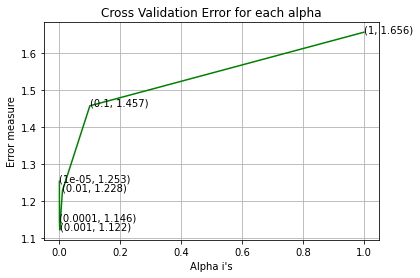

For values of best alpha =  0.001 The train log loss is: 0.6274962794071945
For values of best alpha =  0.001 The cross validation log loss is: 1.1216369975157192
For values of best alpha =  0.001 The test log loss is: 1.3206191179530555


In [49]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=random_state)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=random_state)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


4. Is the text feature useful in predicitng y_i?

Ans. Yes, as it is reducing loss values but it is stable? 

5. Is the Text feature stable across all the data sets (Test, Train, Cross validation)?

Ans. Yes, it seems like! 

In [50]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['Text'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [51]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

95.164 % of word of test data appeared in train data
98.152 % of word of Cross Validation appeared in train data


<h3>4. Data Preprocessing for Modelling</h3>

In [52]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)
    
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

def get_impfeature_names(indices, text, gene, var, no_features):
    """
    this function will be used just for naive bayes. For the given indices, we will print the name of the features
    and we will check whether the feature present in the test point text or not
    """
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['Text'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [53]:
# Stacking the three types of features
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 54591)
(number of data points * number of features) in test data =  (665, 54591)
(number of data points * number of features) in cross validation data = (532, 54591)


In [54]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

print("Response encoding features:")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

Response encoding features:
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)
